# Build a Customer Churn Model for Music Streaming App Users: Overview and Data Preparation


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

---


## Background

This notebook is one of a sequence of notebooks that show you how to use various SageMaker functionalities to build, train, and deploy the model from end to end, including data pre-processing steps like ingestion, cleaning and processing, feature engineering, training and hyperparameter tuning, model explainability, and eventually deploy the model. There are two parts of the demo: 

1. Build a Customer Churn Model for Music Streaming App Users: Overview and Data Preparation (current notebook) - you will process the data with the help of Data Wrangler, then create features from the cleaned data. By the end of part 1, you will have a complete feature data set that contains all attributes built for each user, and it is ready for modeling.
1. Build a Customer Churn Model for Music Streaming App Users: Model Selection and Model Explainability - you will use the data set built from part 1 to find an optimal model for the use case, then test the model predictability with the test data. 

For how to set up the SageMaker Studio Notebook environment, please check the [onboarding video]( https://www.youtube.com/watch?v=wiDHCWVrjCU&feature=youtu.be). And for a list of services covered in the use case demo, please check the documentation linked in each section.


## Content
* [Overview](#Overview)
* [Data Selection](#Data-Selection)
* [Ingest Data](#Ingest-Data)
* [Data Cleaning and Data Exploration](#Data-Cleaning)
* [Pre-processing with SageMaker Data Wrangler](#Pre-processing-with-SageMaker-Data-Wrangler)
* [Feature Engineering with SageMaker Processing](#Feature-Engineering-with-SageMaker-Processing)
* [Data Splitting](#Data-Splitting)

## Overview

### What is Customer Churn and why is it important for businesses?
Customer churn, or customer retention/attrition, means a customer has the tendency to leave and stop paying for a business. It is one of the primary metrics companies want to track to get a sense of their customer satisfaction, especially for a subscription-based business model. The company can track churn rate (defined as the percentage of customers churned during a period) as a health indicator for the business, but we would love to identify the at-risk customers before they churn and offer appropriate treatment to keep them with the business, and this is where machine learning comes into play.

### Use Cases for Customer Churn

Any subscription-based business would track customer churn as one of the most critical Key Performance Indicators (KPIs). Such companies and industries include Telecom companies (cable, cell phone, internet, etc.), digital subscriptions of media (news, forums, blogposts platforms, etc.), music and video streaming services, and other Software as a Service (SaaS) providers (e-commerce, CRM, Mar-Tech, cloud computing, video conference provider, and visualization and data science tools, etc.)

### Define Business problem

To start with, here are some common business problems to consider depending on your specific use cases and your focus:

 * Will this customer churn (cancel the plan, cancel the subscription)?
 * Will this customer downgrade a pricing plan?
 * For a subscription business model, will a customer renew his/her subscription?

### Machine learning problem formulation

#### Classification: will this customer churn?

To goal of classification is to identify the at-risk customers and sometimes their unusual behavior, such as: will this customer churn or downgrade their plan? Is there any unusual behavior for a customer? The latter question can be formulated as an anomaly detection problem.

#### Time Series: will this customer churn in the next X months? When will this customer churn?

You can further explore your users by formulating the problem as a time series one and detect when will the customer churn.

### Data Requirements

#### Data collection Sources

Some most common data sources used to construct a data set for churn analysis are:

* Customer Relationship Management platform (CRM), 
* engagement and usage data (analytics services), 
* passive feedback (ratings based on your request), and active feedback (customer support request, feedback on social media and review platforms).

#### Construct a Data Set for Churn Analysis

Most raw data collected from the sources mentioned above are huge and often needs a lot of cleaning and pre-processing. For example, usage data is usually event-based log data and can be more than a few gigabytes every day; you can aggregate the data to user-level daily for further analysis. Feedback and review data are mostly text data, so you would need to clean and pre-process the natural language data to be normalized, machine-readable data. If you are joining multiple data sources (especially from different platforms) together, you would want to make sure all data points are consistent, and the user identity can be matched across different platforms.
           
#### Challenges with Customer Churn

* Business related
    * Importance of domain knowledge: this is critical when you start building features for the machine learning model. It is important to understand the business enough to decide which features would trigger retention.
* Data issues
    * fewer churn data available (imbalanced classes): data for churn analysis is often very imbalanced as most of the customers of a business are happy customers (usually).
    * User identity mapping problem: if you are joining data from different platforms (CRM, email, feedback, mobile app, and website usage data), you would want to make sure user A is recognized as the same user across multiple platforms. There are third-party solutions that help you tackle this problem.
    * Not collecting the right data for the use case or Lacking enough data

## Data Selection

You will use generated music streaming data that is simulated to imitate music streaming user behaviors. The data simulated contains 1100 users and their user behavior for one year (2019/10/28 - 2020/10/28). Data is simulated using the [EventSim](https://github.com/Interana/eventsim) and does not contain any real user data.

* Observation window: you will use 1 year of data to generate predictions.
* Explanation of fields:
    * `ts`: event UNIX timestamp
    * `userId`: a randomly assigned unique user id
    * `sessionId`: a randomly assigned session id unique to each user
    * `page`: event taken by the user, e.g. "next song", "upgrade", "cancel"
    * `auth`: whether the user is a logged-in user
    * `method`: request method, GET or PUT
    * `status`: request status
    * `level`: if the user is a free or paid user
    * `itemInSession`: event happened in the session
    * `location`: location of the user's IP address
    * `userAgent`: agent of the user's device
    * `lastName`: user's last name
    * `firstName`: user's first name
    * `registration`: user's time of registration
    * `gender`: gender of the user
    * `artist`: artist of the song the user is playing at the event
    * `song`: song title the user is playing at the event
    * `length`: length of the session
 
 
 * the data will be downloaded from Github and contained in an [Amazon Simple Storage Service](https://aws.amazon.com/s3/) (Amazon S3) bucket.

For this specific use case, you will focus on a solution to predict whether a customer will cancel the subscription. Some possible expansion of the work includes:

* predict plan downgrading
* when a user will churn
* add song attributes (genre, playlist, charts) and user attributes (demographics) to the data
* add user feedback and customer service requests to the data


## PART 1: Prepare Data

### Set Up Notebook

In [1]:
!pip install -q 's3fs==0.4.2' 'sagemaker-experiments'
!pip install --upgrade sagemaker boto3
# s3fs is needed for pandas to read files from S3

  Using cached sagemaker-2.232.2-py3-none-any.whl.metadata (16 kB)
  Using cached sagemaker_core-1.0.10-py3-none-any.whl.metadata (4.9 kB)
  Using cached platformdirs-4.3.6-py3-none-any.whl.metadata (11 kB)
  Using cached mock-4.0.3-py3-none-any.whl.metadata (2.8 kB)
Using cached sagemaker-2.232.2-py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 107.7 MB/s eta 0:00:00
Using cached sagemaker_core-1.0.10-py3-none-any.whl (388 kB)
Using cached platformdirs-4.3.6-py3-none-any.whl (18 kB)
Using cached mock-4.0.3-py3-none-any.whl (28 kB)
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.11.0
    Uninstalling platformdirs-3.11.0:
      Successfully uninstalled platformdirs-3.11.0
  Attempting uninstall: mock
    Found existing installation: mock 5.1.0
    Uninstalling mock-5.1.0:
      Successfully uninstalled mock-5.1.0
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.131
    Uninstalling boto

In [2]:
import sagemaker
import json
import pandas as pd
import glob
import s3fs
import boto3
import numpy as np

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### Parameters 
The following lists configurable parameters that are used throughout the whole notebook.

In [3]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()  # replace with your own bucket name if you have one
s3 = sagemaker_session.boto_session.resource("s3")

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
smclient = boto3.Session().client("sagemaker")

prefix = "music-streaming"

### Ingest Data

We ingest the simulated data from the public SageMaker S3 training database.

In [4]:
##### Alternative: copy data from a public S3 bucket to your own bucket
##### data file should include full_data.csv and sample.json
#### cell 5 - 7 is not needed; the processing job before data wrangler screenshots is not needed
!mkdir -p data/raw
s3 = boto3.client("s3")
s3.download_file(
    f"sagemaker-example-files-prod-{region}",
    "datasets/tabular/customer-churn/customer-churn-data-v2.zip",
    "data/raw/customer-churn-data.zip",
)

In [5]:
!unzip -o ./data/raw/customer-churn-data.zip -d ./data

Archive:  ./data/raw/customer-churn-data.zip
  inflating: ./data/validation_w_header.csv  
  inflating: ./data/train_w_header.csv  
  inflating: ./data/processing_job_output.csv  
  inflating: ./data/full_feature_data.csv  
 extracting: ./data/sample.zip       
  inflating: ./data/test.csv         
  inflating: ./data/test_updated.csv  
  inflating: ./data/data_wrangler_output.csv  
  inflating: ./data/sample.csv       
  inflating: ./data/validation_updated.csv  
  inflating: ./data/test_w_header.csv  
  inflating: ./data/train_updated.csv  
 extracting: ./data/simu-4.zip       
 extracting: ./data/simu-3.zip       
 extracting: ./data/simu-2.zip       
 extracting: ./data/simu-1.zip       


In [6]:
# unzip the partitioned data files into the same folder
!unzip -o data/simu-1.zip -d data/raw
!unzip -o data/simu-2.zip -d data/raw
!unzip -o data/simu-3.zip -d data/raw
!unzip -o data/simu-4.zip -d data/raw

Archive:  data/simu-1.zip
  inflating: data/raw/simu-1.json    
Archive:  data/simu-2.zip
  inflating: data/raw/simu-2.json    
Archive:  data/simu-3.zip
  inflating: data/raw/simu-3.json    
Archive:  data/simu-4.zip
  inflating: data/raw/simu-4.json    


In [7]:
!rm ./data/raw/*.zip

In [8]:
!unzip -o data/sample.zip -d data/raw

Archive:  data/sample.zip
  inflating: data/raw/sample.json    


In [9]:
!aws s3 cp  ./data/raw s3://$bucket/$prefix/data/json/  --recursive

upload: data/raw/sample.json to s3://sagemaker-us-west-2-533266972807/music-streaming/data/json/sample.json
upload: data/raw/simu-3.json to s3://sagemaker-us-west-2-533266972807/music-streaming/data/json/simu-3.json
upload: data/raw/simu-1.json to s3://sagemaker-us-west-2-533266972807/music-streaming/data/json/simu-1.json
upload: data/raw/simu-2.json to s3://sagemaker-us-west-2-533266972807/music-streaming/data/json/simu-2.json
upload: data/raw/simu-4.json to s3://sagemaker-us-west-2-533266972807/music-streaming/data/json/simu-4.json


### Data Cleaning

Due to the size of the data (~2GB), you will start exploring our data starting with a smaller sample, decide which pre-processing steps are necessary, and apply them to the whole dataset.

In [10]:
import os

# if your SageMaker Studio notebook's memory is getting full, you can run the following command to remove the raw data files from the instance and free up some memory.
# You will read data from your S3 bucket onwards and will not need the raw data stored in the instance.
os.remove("data/simu-1.zip")
os.remove("data/simu-2.zip")
os.remove("data/simu-3.zip")
os.remove("data/simu-4.zip")
os.remove("data/sample.zip")

In [11]:
sample_file_name = "./data/raw/sample.json"
# s3_sample_file_name =  "data/json/sample.json"
# sample_path = "s3://{}/{}/{}".format(bucket, prefix, s3_sample_file_name)
sample = pd.read_json(sample_file_name, lines=True)

In [12]:
sample.head(2)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1592146267731,12065,118,NextSong,Logged In,PUT,200,paid,0,"Richmond, VA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Davis,Bristol,1.591971e+12,M,Peter Tosh,Wanted Dread And Alive (2002 Digital Remaster),267.85914
1,1592146268731,12065,118,Thumbs Down,Logged In,PUT,307,paid,1,"Richmond, VA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Davis,Bristol,1.591971e+12,M,NaN,NaN,NaN


#### Remove irrelevant columns

From the first look of data, you can notice that columns `lastName`, `firstName`, `method` and `status` are not relevant features. These will be dropped from the data.

In [13]:
columns_to_remove = ["method", "status", "lastName", "firstName"]
sample = sample.drop(columns=columns_to_remove)

#### Check for null values

You are going to remove all events without an `userId` assigned since you are predicting which recognized user will churn from our service. In this case, all the rows(events) have a `userId` and `sessionId` assigned, but you will still run this step for the full dataset. For other columns, there are ~3% of data that are missing some demographic information of the users, and ~20% missing the song attributes, which is because the events contain not only playing a song, but also other actions including login and log out, downgrade, cancellation, etc. There are ~3% of users that do not have a registration time, so you will remove these anonymous users from the record.

In [14]:
print("percentage of the value missing in each column is: ")
sample.isnull().sum() / len(sample)

percentage of the value missing in each column is: 


ts               0.000000
userId           0.000000
sessionId        0.000000
page             0.000000
auth             0.000000
level            0.000000
itemInSession    0.000000
location         0.025447
userAgent        0.025447
registration     0.025447
gender           0.025447
artist           0.210330
song             0.210330
length           0.210330
dtype: float64

In [15]:
sample = sample[~sample["userId"].isnull()]
sample = sample[~sample["registration"].isnull()]

### Data Exploration

Let's take a look at our categorical columns first: `page`, `auth`, `level`, `location`, `userAgent`, `gender`, `artist`, and `song`, and start with looking at unique values for `page`, `auth`, `level`, and `gender` since the other three have many unique values and you will take a different approach.

In [16]:
cat_columns = ["page", "auth", "level", "gender"]
cat_columns_long = ["location", "userAgent", "artist", "song", "userId"]
for col in cat_columns:
    print("The unique values in column {} are: {}".format(col, sample[col].unique()))
for col in cat_columns_long:
    print("There are {} unique values  in column {}".format(sample[col].nunique(), col))

The unique values in column page are: ['NextSong' 'Thumbs Down' 'Home' 'Settings' 'Thumbs Up' 'Add to Playlist'
 'Roll Advert' 'Save Settings' 'Help' 'Logout' 'Add Friend' 'Downgrade'
 'About' 'Upgrade' 'Error' 'Submit Upgrade' 'Submit Downgrade' 'Cancel'
 'Cancellation Confirmation']
The unique values in column auth are: ['Logged In' 'Cancelled']
The unique values in column level are: ['paid' 'free']
The unique values in column gender are: ['M' 'F']
There are 72 unique values  in column location
There are 37 unique values  in column userAgent
There are 16207 unique values  in column artist
There are 51447 unique values  in column song
There are 101 unique values  in column userId


#### Key observations from the above information

* There are 101 unique users with 72 unique locations, this information may not be useful as a categorical feature. You can parse this field and only keep State information, but even that will give us 50 unique values in this category, so you can either remove this column or bucket it to a higher level (NY --> Northeast).
* Artist and song details might not be helpful as categorical features as there are too many categories; you can quantify these to a user level, i.e. how many artists this user has listened to in total, how many songs this user has played in the last week, last month, in 180 days, in 365 days. You can also bring in external data to get song genres and other artist attributes to enrich this feature.
* In the column `page`,  'Thumbs Down', 'Thumbs Up', 'Add to Playlist', 'Roll Advert','Help', 'Add Friend', 'Downgrade', 'Upgrade', and 'Error' can all be great features to churn analysis. You will aggregate them to user-level later. There is a "cancellation confirmation" value that can be used for the churn indicator.

* Let's take a look at the column `userAgent`:


UserAgent contains little useful information, but if you care about the browser type and mac/windows difference, you can parse the text and extract the information. Sometimes businesses would love to analyze user behavior based on their App version and device type (iOS v.s. Android), so these could be useful information. In this use case, for modeling purpose, we will remove this column. but you can keep it as a filter for data visualization.

In [17]:
columns_to_remove = ["location", "userAgent"]
sample = sample.drop(columns=columns_to_remove)

Let's take a closer look at the timestamp columns `ts` and `registration`. We can convert the event timestamp `ts` to year, month, week, day, day of the week, and hour of the day. The registration time should be the same for the same user, so we can aggregate this value to user-level and create a time delta column to calculate the time between registration and the newest event.

In [18]:
sample["date"] = pd.to_datetime(sample["ts"], unit="ms")
sample["ts_year"] = sample["date"].dt.year
sample["ts_month"] = sample["date"].dt.month
sample["ts_day"] = sample["date"].dt.day
sample["ts_dow"] = sample["date"].dt.weekday
sample["ts_hour"] = sample["date"].dt.hour
sample["ts_date_day"] = sample["date"].dt.date
sample["ts_is_weekday"] = [1 if x in [0, 1, 2, 3, 4] else 0 for x in sample["ts_dow"]]
sample["registration_ts"] = pd.to_datetime(sample["registration"], unit="ms").dt.date

#### Define Churn

In this use case, you will use `page == "Cancellation Confirmation"` as the indicator of a user churn. You can also use `page == 'downgrade` if you are interested in users downgrading their payment plan. There are ~13% users churned, so you will need to up-sample or down-sample the full dataset to deal with the imbalanced class, or carefully choose your algorithms.

In [19]:
print(
    "There are {:.2f}% of users churned in this dataset".format(
        (
            (sample[sample["page"] == "Cancellation Confirmation"]["userId"].nunique())
            / sample["userId"].nunique()
        )
        * 100
    )
)

There are 12.87% of users churned in this dataset


You can label a user by adding a churn label at a event level then aggregate this value to user level. 

In [20]:
sample["churned_event"] = [1 if x == "Cancellation Confirmation" else 0 for x in sample["page"]]
sample["user_churned"] = sample.groupby("userId")["churned_event"].transform("max")

#### Imbalanced Class

Imbalanced class (much more positive cases than negative cases) is very common in churn analysis. It can be misleading for some machine learning model as the accuracy will be biased towards the majority class. Some useful tactics to deal with imbalanced class are [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html), use algorithms that are less sensitive to imbalanced class like a tree-based algorithm or use a cost-sensitive algorithm that penalizes wrongly classified minority class.

To Summarize every pre-processing steps you have covered:
* null removals
* drop irrelevant columns
* convert event timestamps to features used for analysis and modeling: year, month, week, day, day of week, hour, date, if the day is weekday or weekend, and convert registration timestamp to UTC.
* create labels (whether the user churned eventually), which is calculated by if one churn event happened in the user's history, you can label the user as a churned user (1). 

#### Exploring Data

Based on the available data, look at every column, and decide if you can create a feature from it. For all the columns, here are some directions to explore:

    * `ts`: distribution of activity time: time of the day, day of the week
    * `sessionId`: average number of sessions per user
    * `page`:  number of thumbs up/thumbs down, added to the playlist, ads, add friend, if the user has downgrade or upgrade the plan, how many errors the user has encountered.
    * `level`: if the user is a free or paid user
    * `registration`: days the user being active, time the user joined the service
    * `gender`: gender of the user
    * `artist`: average number of artists the user listened to
    * `song`: average number of songs listened per user
    * `length`: average time spent per day per user
   
**Activity Time**

1. Weekday v.s. weekend trends for churned users and active users. It seems like churned users are more active on weekdays than weekends whereas active users do not show a strong difference between weekday v.s. weekends. You can create some features from here: for each user, average events per day -- weekends, average events per day -- weekdays. You can also create features - average events per day of the week, but that will be converted to 7 features after one-hot-encoding, which may be less informative than the previous method.
2. In terms of hours active during a day, our simulated data did not show a significant difference between day and night for both sets of users. You can have it on your checklist for your analysis, and similarly for the day of the month, the month of the year when you have more than a year of data.

In [21]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


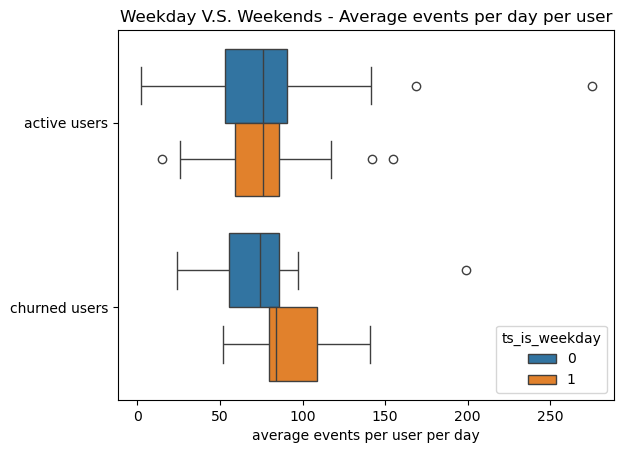

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

events_per_day_per_user = (
    sample.groupby(["userId", "ts_date_day", "ts_is_weekday", "user_churned"])
    .agg({"page": "count"})
    .reset_index()
)
events_dist = (
    events_per_day_per_user.groupby(["userId", "ts_is_weekday", "user_churned"])
    .agg({"page": "mean"})
    .reset_index()
)


def trend_plot(
    df, plot_type, x, y, hue=None, title=None, x_axis=None, y_axis=None, xticks=None, yticks=None
):
    if plot_type == "box":
        fig = sns.boxplot(x="page", y=y, data=df, hue=hue, orient="h")
    elif plot_type == "bar":
        fig = sns.barplot(x=x, y=y, data=df, hue=hue)

    sns.set(rc={"figure.figsize": (12, 3)})
    sns.set_palette("Set2")
    sns.set_style("darkgrid")
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.yticks([0, 1], yticks)
    return plt.show(fig)


trend_plot(
    events_dist,
    "box",
    "page",
    "user_churned",
    "ts_is_weekday",
    "Weekday V.S. Weekends - Average events per day per user",
    "average events per user per day",
    yticks=["active users", "churned users"],
)

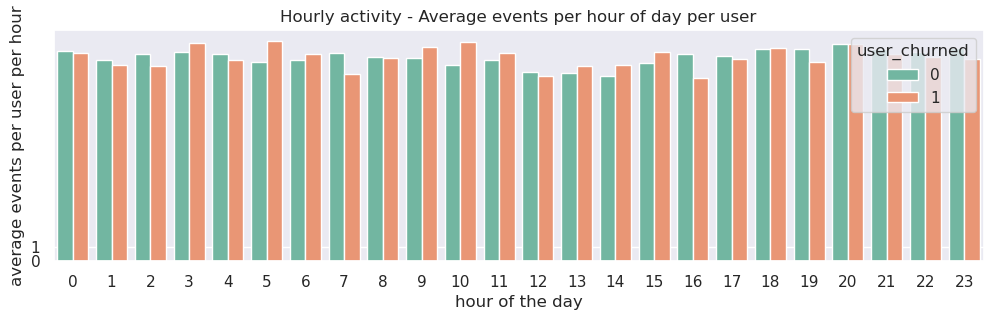

In [23]:
events_per_hour_per_user = (
    sample.groupby(["userId", "ts_date_day", "ts_hour", "user_churned"])
    .agg({"page": "count"})
    .reset_index()
)
events_dist = (
    events_per_hour_per_user.groupby(["userId", "ts_hour", "user_churned"])
    .agg({"page": "mean"})
    .reset_index()
    .groupby(["ts_hour", "user_churned"])
    .agg({"page": "mean"})
    .reset_index()
)
trend_plot(
    events_dist,
    "bar",
    "ts_hour",
    "page",
    "user_churned",
    "Hourly activity - Average events per hour of day per user",
    "hour of the day",
    "average events per user per hour",
)

**Listening Behavior**

You can look at some basic stats for a user's listening habits. Churned users generally listen to a wider variety of songs and artists and spend more time on the App/be with the App longer.
* Average total: number of sessions, App usage length, number of songs listened, number of artists listened per user, number of ad days active
* Average daily: number of sessions, App usage length, number of songs listened, number of artists listened per user


In [24]:
stats_per_user = (
    sample.groupby(["userId", "user_churned"])
    .agg(
        {
            "sessionId": "count",
            "song": "nunique",
            "artist": "nunique",
            "length": "sum",
            "ts_date_day": "count",
        }
    )
    .reset_index()
)
avg_stats_group = (
    stats_per_user.groupby(["user_churned"])
    .agg(
        {
            "sessionId": "mean",
            "song": "mean",
            "artist": "mean",
            "length": "mean",
            "ts_date_day": "mean",
        }
    )
    .reset_index()
)

print(
    "Average total: number of sessions, App usage length, number of songs listened, number of artists listened per user, days active: "
)
avg_stats_group

Average total: number of sessions, App usage length, number of songs listened, number of artists listened per user, days active: 


,user_churned,sessionId,song,artist,length,ts_date_day
0,0,2044.636364,1434.102273,1067.602273,412310.642096,2044.636364
1,1,3260.384615,2173.153846,1493.230769,656340.586522,3260.384615


In [25]:
stats_per_user = (
    sample.groupby(["userId", "ts_date_day", "user_churned"])
    .agg({"sessionId": "count", "song": "nunique", "artist": "nunique", "length": "sum"})
    .reset_index()
)
avg_stats_group = (
    stats_per_user.groupby(["user_churned"])
    .agg({"sessionId": "mean", "song": "mean", "artist": "mean", "length": "mean"})
    .reset_index()
)
print(
    "Average daily: number of sessions, App usage length, number of songs listened, number of artists listened per user: "
)
avg_stats_group

Average daily: number of sessions, App usage length, number of songs listened, number of artists listened per user: 


,user_churned,sessionId,song,artist,length
0,0,76.597701,61.301831,59.323116,15446.290551
1,1,92.746171,74.291028,71.501094,18670.519967


**App Usage Behavior**

You can further explore how the users are using the App besides just listening: number of thumbs up/thumbs down, added to playlist, ads, add friend, if the user has downgrade or upgrade the plan, how many errors the user has encountered. Churned users are slightly more active than other users, and also encounter more errors, listened to more ads, and more downgrade and upgrade. These can be numerical features (number of total events per type per user), or more advanced time series numerical features (errors in last 7 days, errors in last month, etc.).

In [26]:
events_list = [
    "NextSong",
    "Thumbs Down",
    "Thumbs Up",
    "Add to Playlist",
    "Roll Advert",
    "Add Friend",
    "Downgrade",
    "Upgrade",
    "Error",
]
usage_column_name = []
for event in events_list:
    event_name = "_".join(event.split()).lower()
    usage_column_name.append(event_name)
    sample[event_name] = [1 if x == event else 0 for x in sample["page"]]

In [27]:
app_use_per_user = sample.groupby(["userId", "user_churned"])[usage_column_name].sum().reset_index()

In [28]:
app_use_group = app_use_per_user.groupby(["user_churned"])[usage_column_name].mean().reset_index()
app_use_group

,user_churned,nextsong,thumbs_down,thumbs_up,add_to_playlist,roll_advert,add_friend,downgrade,upgrade,error
0,0,1656.204545,16.988636,150.477273,50.863636,7.613636,29.181818,9.568182,1.954545,2.193182
1,1,2645.538462,28.076923,239.615385,80.846154,10.923077,48.923077,12.615385,2.461538,3.461538


## Pre-processing with SageMaker Data Wrangler

Now that you have a good understanding of your data and decided which steps are needed to pre-process your data, you can utilize the new Amazon SageMaker GUI tool **Data Wrangler**, without writing all the code for the SageMaker Processing Job.

* Here we used a Processing Job to convert the raw streaming data files downloaded from the github repo (`simu-*.zip` files) to a full, CSV formatted file for Data Wrangler Ingestion purpose.
you are importing the raw streaming data files downloaded from the github repo (`simu-*.zip` files). The raw JSON files were converted to CSV format and combined to one file for Data Wrangler Ingestion purpose.

In [29]:
!pip install -U sagemaker

In [30]:
%%writefile preprocessing_predw.py

import argparse
import os
import warnings
import glob
import time
import pandas as pd
import json
import argparse

from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)
start_time = time.time()

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--processing-output-filename")

    args, _ = parser.parse_known_args()
    print("Received arguments {}".format(args))

    input_jsons = glob.glob("/opt/ml/processing/input/data/**/*.json", recursive=True)

    df_all = pd.DataFrame()
    for name in input_jsons:
        print("\nStarting file: {}".format(name))
        df = pd.read_json(name, lines=True)
        df_all = df_all.append(df)

    output_filename = args.processing_output_filename
    final_features_output_path = os.path.join("/opt/ml/processing/output", output_filename)
    print("Saving processed data to {}".format(final_features_output_path))
    df_all.to_csv(final_features_output_path, header=True, index=False)

Overwriting preprocessing_predw.py


In [31]:
from sagemaker.sklearn.processing import SKLearnProcessor

sklearn_processor = SKLearnProcessor(
    framework_version="1.2-1", role=role, instance_type="ml.m5.xlarge", instance_count=1
)

In [32]:
s3_client = boto3.client("s3")
list_response = s3_client.list_objects_v2(Bucket=bucket, Prefix=f"{prefix}/data/json")
s3_input_uris = [f"s3://{bucket}/{i['Key']}" for i in list_response["Contents"]]
s3_input_uris

['s3://sagemaker-us-west-2-533266972807/music-streaming/data/json/sample.json',
 's3://sagemaker-us-west-2-533266972807/music-streaming/data/json/simu-1.json',
 's3://sagemaker-us-west-2-533266972807/music-streaming/data/json/simu-2.json',
 's3://sagemaker-us-west-2-533266972807/music-streaming/data/json/simu-3.json',
 's3://sagemaker-us-west-2-533266972807/music-streaming/data/json/simu-4.json']

In [33]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

processing_inputs = []
for i in s3_input_uris:
    name = i.split("/")[-1].split(".")[0]
    processing_input = ProcessingInput(
        source=i, input_name=name, destination=f"/opt/ml/processing/input/data/{name}"
    )
    processing_inputs.append(processing_input)

In [34]:
%%time
processing_output_path = f"s3://{bucket}/{prefix}/data/processing"
final_features_filename = "full_data.csv"

sklearn_processor.run(
    code="preprocessing_predw.py",
    inputs=processing_inputs,
    outputs=[
        ProcessingOutput(
            output_name="processed_data",
            source="/opt/ml/processing/output",
            destination=processing_output_path,
        )
    ],
    arguments=["--processing-output-filename", final_features_filename],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2024-10-16-06-50-25-621


............Received arguments Namespace(processing_output_filename='full_data.csv')
Starting file: /opt/ml/processing/input/data/simu-2/simu-2.json
Starting file: /opt/ml/processing/input/data/simu-4/simu-4.json
Starting file: /opt/ml/processing/input/data/simu-3/simu-3.json
Starting file: /opt/ml/processing/input/data/simu-1/simu-1.json
Starting file: /opt/ml/processing/input/data/sample/sample.json
Saving processed data to /opt/ml/processing/output/full_data.csv

CPU times: user 1.12 s, sys: 51 ms, total: 1.17 s
Wall time: 7min 58s


Now you can initiate a Data Wrangler flow. An example flow (`dw_example.flow`) is provided in the github repo. 

From the SageMaker Studio launcher page, choose **New data flow**, then choose **import from S3** and select processing_output_filename. 

<div>
<img src="image/mo1.PNG" width="600"/>
   </div>
   
You can import any .csv format file with SageMaker Data Wrangler, preview your data, and decide what pre-processing steps are needed.
  <div>
<img src="image/mo2.PNG" width="600"/>
   </div> 
You can choose your pre-processing steps, including drop columns and rename columns from the pre-built solutions, also customize processing and feature engineering code in the custom Pandas code block.
<div>
<img src="image/mo3.PNG" width="600"/>

</div>
After everything run through, it will create a Processing job notebook for you. You can run through the notebook to kick off the Processing Job and check the status in the console.

<div>
<img src="image/mo4.PNG" width="600"/>

</div>

#### Find the data path of the SageMaker Data Wrangler Job

You can get the results from your Data Wrangler Job, check the results, and use it as input for your feature engineering processing job.

In [35]:
processing_output_filename = f"{processing_output_path}/{final_features_filename}"
processing_output_filename

's3://sagemaker-us-west-2-533266972807/music-streaming/data/processing/full_data.csv'

In [36]:
flow_file = "dw_example.flow"

# read flow file and change the s3 location to our `processing_output_filename`
with open(flow_file, "r") as f:
    flow = f.read()

    flow = json.loads(flow)
    flow["nodes"][0]["parameters"]["dataset_definition"]["s3ExecutionContext"][
        "s3Uri"
    ] = processing_output_filename

with open("dw_example.flow", "w") as f:
    json.dump(flow, f)
flow

{'metadata': {'version': 1},
 'nodes': [{'node_id': '660c3ee3-5207-4ded-b92f-7059831a7aed',
   'type': 'SOURCE',
   'operator': 'sagemaker.s3_source_0.1',
   'parameters': {'dataset_definition': {'__typename': 'S3CreateDatasetDefinitionOutput',
     'datasetSourceType': 'S3',
     'name': 'full_data.csv',
     'description': None,
     's3ExecutionContext': {'__typename': 'S3ExecutionContext',
      's3Uri': 's3://sagemaker-us-west-2-533266972807/music-streaming/data/processing/full_data.csv',
      's3ContentType': 'csv',
      's3HasHeader': True}}},
   'inputs': [],
   'outputs': [{'name': 'default',
     'sampling': {'sampling_method': 'sample_by_ratio',
      'sample_ratio': 0.06460757939298588}}]},
  {'node_id': 'd04eac2a-92a9-4539-b22f-f0f30aa29877',
   'type': 'TRANSFORM',
   'operator': 'sagemaker.spark.infer_and_cast_type_0.1',
   'parameters': {},
   'trained_parameters': {'schema': {'ts': 'long',
     'userId': 'long',
     'sessionId': 'long',
     'page': 'string',
     '

## Feature Engineering with SageMaker Processing


For user churn analysis, usually, you can consider build features from the following aspects:

* Generate base features:
     * user behavior features (listening behavior, app behavior).
     * customer demographic features.
     * customer support features (interactions, ratings, etc.)
* Formulate time series as features:
    * construct streaming time as time series.
    * build features in the different time windows (e.g. total songs listened in the last 7 days, 30 days, 180 days, etc.)
   
For this use case, after exploring the data and with all the findings you gathered, now is the time to create features used for your model. Since the data set is time series, you can enrich your features by adding a time factor to it: e.g., for the total number of songs listened, you can create features like total songs listened in the last 7 days, last 30 days, last 90 days, last 180 days, etc. The features built for these use cases will be at the user level - each row represents one user, and will include the following:

* daily features:
     * average_events_weekday (numerical): average number of events per day during weekday
     * average_events_weekend (numerical): average number of events per day during the weekend
     * num_ads_7d: number of ads in last 7 days
     * num_error_7d: total errors encountered in last 7 days
     * num_songs_played_7d: total songs played in last 7 days
     * num_songs_played_30d: total songs played in last 30 days
     * num_songs_played_90d: total songs played in last 90 days
* user features:
     * num_artists (numerical): number of artists the user has listened to
     * num_songs (numerical): number of songs played
     * num_ads (numerical): number of ads played
     * num_thumbsup (numerical): number of times the user likes a song
     * num_thumbsdown (numerical): number of times the user dislikes a song
     * num_playlist (numerical): number of times user adds a song to a playlist
     * num_addfriend (numerical): number of times user adds a friend
     * num_error (numerical): number of times user encountered an error
     * user_downgrade (binary): user has downgraded plan
     * user_upgrade (binary): user has upgraded plan
     * percentage_song: percentage of the user's action is 'NextSong' (only listens to songs) 
     * percentage_ad: percentage of the user's action is 'Roll Advert'
     * repeats_ratio: percentage of total songs that are repeats
     * days_since_active: days since the user registered and leave (if the user cancels)
* Session features:
     * num_sessions: number of total sessions
     * avg_time_per_session: average time spent per session
     * avg_events_per_session: average number of events per session
     * avg_gap_between_session: average time between sessions
   
The following function will create the processing job with SageMaker Processing, a new Python SDK that lets data scientists and ML engineers easily run preprocessing, postprocessing and model evaluation workloads on Amazon SageMaker. This SDK uses SageMaker’s built-in container for scikit-learn, possibly the most popular library for data set transformation.
You can find a complete guide to the SageMaker Processing job in [this blog](https://aws.amazon.com/blogs/aws/amazon-sagemaker-processing-fully-managed-data-processing-and-model-evaluation/).

In [37]:
from sagemaker.sklearn.processing import SKLearnProcessor

sklearn_processor = SKLearnProcessor(
    #     framework_version='0.20.0',
    framework_version="1.2-1",
    role=role,
    instance_type="ml.m5.xlarge",
    instance_count=1,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [38]:
### SAVE THE OUTPUT FILE NAME FROM PROCESSING JOB
processing_job_output_name = "processing_job_output.csv"

In [39]:
%%writefile preprocessing.py

import sys
import subprocess

import os
import warnings
import time
import argparse
import boto3
import pandas as pd

start_time = time.time()

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--dw-output-path")
    parser.add_argument("--processing-output-filename")

    args, _ = parser.parse_known_args()
    print("Received arguments {}".format(args))

    data_s3_uri = args.dw_output_path
    output_filename = args.processing_output_filename

    bucket = data_s3_uri.split("/")[2]
    key = "/".join(data_s3_uri.split("/")[3:] + ["full_data.csv"])
    s3_client = boto3.client("s3")
    s3_client.download_file(bucket, key, "full_data.csv")
    df = pd.read_csv("full_data.csv")

    ## convert to time
    df["date"] = pd.to_datetime(df["ts"], unit="ms")
    df["ts_dow"] = df["date"].dt.weekday
    df["ts_date_day"] = df["date"].dt.date
    df["ts_is_weekday"] = [1 if x in [0, 1, 2, 3, 4] else 0 for x in df["ts_dow"]]
    df["registration_ts"] = pd.to_datetime(df["registration"], unit="ms").dt.date
    ## add labels
    df["churned_event"] = [1 if x == "Cancellation Confirmation" else 0 for x in df["page"]]
    df["user_churned"] = df.groupby("userId")["churned_event"].transform("max")

    ## convert pages categorical variables to numerical
    events_list = [
        "NextSong",
        "Thumbs Down",
        "Thumbs Up",
        "Add to Playlist",
        "Roll Advert",
        "Add Friend",
        "Downgrade",
        "Upgrade",
        "Error",
    ]
    usage_column_name = []
    for event in events_list:
        event_name = "_".join(event.split()).lower()
        usage_column_name.append(event_name)
        df[event_name] = [1 if x == event else 0 for x in df["page"]]
    ## feature engineering
    # average_events_weekday (numerical): average number of events per day during weekday
    # average_events_weekend (numerical): average number of events per day during the weekend
    base_df = (
        df.groupby(["userId", "ts_date_day", "ts_is_weekday"])
        .agg({"page": "count"})
        .groupby(["userId", "ts_is_weekday"])["page"]
        .mean()
        .unstack(fill_value=0)
        .reset_index()
        .rename(columns={0: "average_events_weekend", 1: "average_events_weekday"})
    )

    # num_ads_7d, num_songs_played_7d, num_songs_played_30d, num_songs_played_90d, num_ads_7d, num_error_7d
    base_df_daily = (
        df.groupby(["userId", "ts_date_day"])
        .agg({"page": "count", "nextsong": "sum", "roll_advert": "sum", "error": "sum"})
        .reset_index()
    )
    feature34 = (
        base_df_daily.groupby(["userId", "ts_date_day"])
        .tail(7)
        .groupby(["userId"])
        .agg({"nextsong": "sum", "roll_advert": "sum", "error": "sum"})
        .reset_index()
        .rename(
            columns={
                "nextsong": "num_songs_played_7d",
                "roll_advert": "num_ads_7d",
                "error": "num_error_7d",
            }
        )
    )
    feature5 = (
        base_df_daily.groupby(["userId", "ts_date_day"])
        .tail(30)
        .groupby(["userId"])
        .agg({"nextsong": "sum"})
        .reset_index()
        .rename(columns={"nextsong": "num_songs_played_30d"})
    )
    feature6 = (
        base_df_daily.groupby(["userId", "ts_date_day"])
        .tail(90)
        .groupby(["userId"])
        .agg({"nextsong": "sum"})
        .reset_index()
        .rename(columns={"nextsong": "num_songs_played_90d"})
    )
    # num_artists, num_songs, num_ads, num_thumbsup, num_thumbsdown, num_playlist, num_addfriend, num_error, user_downgrade,
    # user_upgrade, percentage_ad, days_since_active
    base_df_user = (
        df.groupby(["userId"])
        .agg(
            {
                "page": "count",
                "nextsong": "sum",
                "artist": "nunique",
                "song": "nunique",
                "thumbs_down": "sum",
                "thumbs_up": "sum",
                "add_to_playlist": "sum",
                "roll_advert": "sum",
                "add_friend": "sum",
                "downgrade": "max",
                "upgrade": "max",
                "error": "sum",
                "ts_date_day": "max",
                "registration_ts": "min",
                "user_churned": "max",
            }
        )
        .reset_index()
    )
    base_df_user["percentage_ad"] = base_df_user["roll_advert"] / base_df_user["page"]
    base_df_user["days_since_active"] = (
        base_df_user["ts_date_day"] - base_df_user["registration_ts"]
    ).dt.days
    # repeats ratio
    base_df_user["repeats_ratio"] = 1 - base_df_user["song"] / base_df_user["nextsong"]

    # num_sessions, avg_time_per_session, avg_events_per_session,
    base_df_session = (
        df.groupby(["userId", "sessionId"])
        .agg({"length": "sum", "page": "count", "date": "min"})
        .reset_index()
    )
    base_df_session["prev_session_ts"] = base_df_session.groupby(["userId"])["date"].shift(1)
    base_df_session["gap_session"] = (
        base_df_session["date"] - base_df_session["prev_session_ts"]
    ).dt.days
    user_sessions = (
        base_df_session.groupby("userId")
        .agg({"sessionId": "count", "length": "mean", "page": "mean", "gap_session": "mean"})
        .reset_index()
        .rename(
            columns={
                "sessionId": "num_sessions",
                "length": "avg_time_per_session",
                "page": "avg_events_per_session",
                "gap_session": "avg_gap_between_session",
            }
        )
    )

    # merge features together
    base_df["userId"] = base_df["userId"].astype("int")
    final_feature_df = base_df.merge(feature34, how="left", on="userId")
    final_feature_df = final_feature_df.merge(feature5, how="left", on="userId")
    final_feature_df = final_feature_df.merge(feature6, how="left", on="userId")
    final_feature_df = final_feature_df.merge(user_sessions, how="left", on="userId")
    final_feature_df = final_feature_df.merge(base_df_user, how="left", on="userId")

    final_feature_df = final_feature_df.fillna(0)
    # renaming columns
    final_feature_df.columns = [
        "userId",
        "average_events_weekend",
        "average_events_weekday",
        "num_songs_played_7d",
        "num_ads_7d",
        "num_error_7d",
        "num_songs_played_30d",
        "num_songs_played_90d",
        "num_sessions",
        "avg_time_per_session",
        "avg_events_per_session",
        "avg_gap_between_session",
        "num_events",
        "num_songs",
        "num_artists",
        "num_unique_songs",
        "num_thumbs_down",
        "num_thumbs_up",
        "num_add_to_playlist",
        "num_ads",
        "num_add_friend",
        "num_downgrade",
        "num_upgrade",
        "num_error",
        "ts_date_day",
        "registration_ts",
        "user_churned",
        "percentage_ad",
        "days_since_active",
        "repeats_ratio",
    ]
    # only keep created feature columns
    final_feature_df = final_feature_df[
        [
            "userId",
            "user_churned",
            "average_events_weekend",
            "average_events_weekday",
            "num_songs_played_7d",
            "num_ads_7d",
            "num_error_7d",
            "num_songs_played_30d",
            "num_songs_played_90d",
            "num_sessions",
            "avg_time_per_session",
            "avg_events_per_session",
            "avg_gap_between_session",
            "num_events",
            "num_songs",
            "num_artists",
            "num_thumbs_down",
            "num_thumbs_up",
            "num_add_to_playlist",
            "num_ads",
            "num_add_friend",
            "num_downgrade",
            "num_upgrade",
            "num_error",
            "percentage_ad",
            "days_since_active",
            "repeats_ratio",
        ]
    ]

    print("shape of file to append:\t\t{}".format(final_feature_df.shape))
    iter_end_time = time.time()
    end_time = time.time()
    print("minutes elapsed: {}".format(str((end_time - start_time) / 60)))

    final_features_output_path = os.path.join("/opt/ml/processing/output", output_filename)
    print("Saving processed data to {}".format(final_features_output_path))
    final_feature_df.to_csv(final_features_output_path, header=True, index=False)

Overwriting preprocessing.py


In [40]:
output_path = processing_output_filename

In [41]:
%%time
from sagemaker.processing import ProcessingInput, ProcessingOutput

processing_job_output_path = f"s3://{bucket}/{prefix}/data/processing"

sklearn_processor.run(
    code="preprocessing.py",
    outputs=[
        ProcessingOutput(
            output_name="processed_data",
            source="/opt/ml/processing/output",
            destination=processing_job_output_path,
        )
    ],
    arguments=[
        "--dw-output-path",
        processing_job_output_path,
        "--processing-output-filename",
        processing_job_output_name,
    ],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2024-10-16-06-58-24-168


...........Received arguments Namespace(dw_output_path='s3://sagemaker-us-west-2-533266972807/music-streaming/data/processing', processing_output_filename='processing_job_output.csv')
shape of file to append:#011#011(1014, 27)
minutes elapsed: 1.0555336991945903
Saving processed data to /opt/ml/processing/output/processing_job_output.csv

CPU times: user 806 ms, sys: 29.9 ms, total: 836 ms
Wall time: 5min 24s


In [42]:
preprocessing_job_description

{'ProcessingInputs': [{'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-533266972807/sagemaker-scikit-learn-2024-10-16-06-58-24-168/input/code/preprocessing.py',
    'LocalPath': '/opt/ml/processing/input/code',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'processed_data',
    'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-533266972807/music-streaming/data/processing',
     'LocalPath': '/opt/ml/processing/output',
     'S3UploadMode': 'EndOfJob'},
    'AppManaged': False}]},
 'ProcessingJobName': 'sagemaker-scikit-learn-2024-10-16-06-58-24-168',
 'ProcessingResources': {'ClusterConfig': {'InstanceCount': 1,
   'InstanceType': 'ml.m5.xlarge',
   'VolumeSizeInGB': 30}},
 'StoppingCondition': {'MaxRuntimeInSeconds': 86400},
 'AppSpecification': {'ImageUri': '246618743249.dkr.ecr.us-west-2.am

Congratulations! You have preprocessed the data. You can proceed to modelling.

### Data Splitting

You formulated the use case as a classification problem on user level, so you can randomly split your data from last step into train/validation/test. If you want to predict "will user X churn in the next Y days" on per user per day level, you should think about spliting data in chronological order instead of random. 

You should split the data and make sure that data of both classes exist in your train, validation and test sets, to make sure both classes are represented in your data. 

#### Find the output of Processing Job

In [43]:
processing_job_output_uri = f"{processing_job_output_path}/{processing_job_output_name}"
processing_job_output_uri

's3://sagemaker-us-west-2-533266972807/music-streaming/data/processing/processing_job_output.csv'

In [44]:
!aws s3 cp $processing_job_output_uri ./data

download: s3://sagemaker-us-west-2-533266972807/music-streaming/data/processing/processing_job_output.csv to data/processing_job_output.csv


In [45]:
processed_data = pd.read_csv(processing_job_output_uri)

In [46]:
# Optional: you can also load the processed data from the provided feature set
# processed_data = pd.read_csv('./data/full_feature_data.csv')

In [47]:
processed_data.head(4)

,userId,user_churned,average_events_weekend,average_events_weekday,num_songs_played_7d,num_ads_7d,num_error_7d,num_songs_played_30d,num_songs_played_90d,num_sessions,...,num_thumbs_up,num_add_to_playlist,num_ads,num_add_friend,num_downgrade,num_upgrade,num_error,percentage_ad,days_since_active,repeats_ratio
0,11001,0.0,94.9375,76.304348,4135,7,1,4135,4135,51,...,293,140,7,81,1,1,1,0.001392,359,0.179444
1,11002,0.0,70.5000,76.666667,476,1,0,476,476,7,...,41,16,1,14,1,0,0,0.001664,265,0.052521
2,11003,1.0,98.7500,120.875000,3867,12,9,3867,3867,37,...,272,103,12,69,1,1,9,0.002576,66,0.175330
3,11004,1.0,70.0000,120.444444,1084,2,1,1084,1084,7,...,68,30,2,9,1,0,1,0.001546,48,0.076568


#### Split data to train/validation/test by 70/20/10

In [48]:
data = processed_data.sample(frac=1, random_state=1729)
grouped_df = data.groupby("user_churned")
arr_list = [np.split(g, [int(0.7 * len(g)), int(0.9 * len(g))]) for i, g in grouped_df]

train_data = pd.concat([t[0] for t in arr_list])
validation_data = pd.concat([t[1] for t in arr_list])
test_data = pd.concat([v[2] for v in arr_list])

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [49]:
def process_data(data, name, header=False):
    data = data.drop(columns=["userId"])
    data = pd.concat([data["user_churned"], data.drop(["user_churned"], axis=1)], axis=1)
    data.to_csv(name, header=header, index=False)

In [50]:
process_data(train_data, "data/train_updated.csv")
process_data(validation_data, "data/validation_updated.csv")
process_data(test_data, "data/test_updated.csv")

process_data(train_data, "data/train_w_header.csv", header=True)
process_data(validation_data, "data/validation_w_header.csv", header=True)
process_data(test_data, "data/test_w_header.csv", header=True)

#### Save splitted data to S3
The splitted data is provided in the /data folder. You can also upload the provided files (`data/train_updated.csv`,`data/validation_updated.csv`, `data/test_updated.csv`) and proceed to the next step. 

In [51]:
import os

s3_input_train = (
    boto3.Session()
    .resource("s3")
    .Bucket(bucket)
    .Object(os.path.join(prefix, "train/train.csv"))
    .upload_file("data/train_updated.csv")
)
s3_input_validation = (
    boto3.Session()
    .resource("s3")
    .Bucket(bucket)
    .Object(os.path.join(prefix, "validation/validation.csv"))
    .upload_file("data/validation_updated.csv")
)
s3_input_validation = (
    boto3.Session()
    .resource("s3")
    .Bucket(bucket)
    .Object(os.path.join(prefix, "test/test_labeled.csv"))
    .upload_file("data/test_updated.csv")
)

### Citation
The data used in this notebook is simulated using the [EventSim](https://github.com/Interana/eventsim).

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/use-cases|customer_churn|1_cust_churn_dataprep.ipynb)
